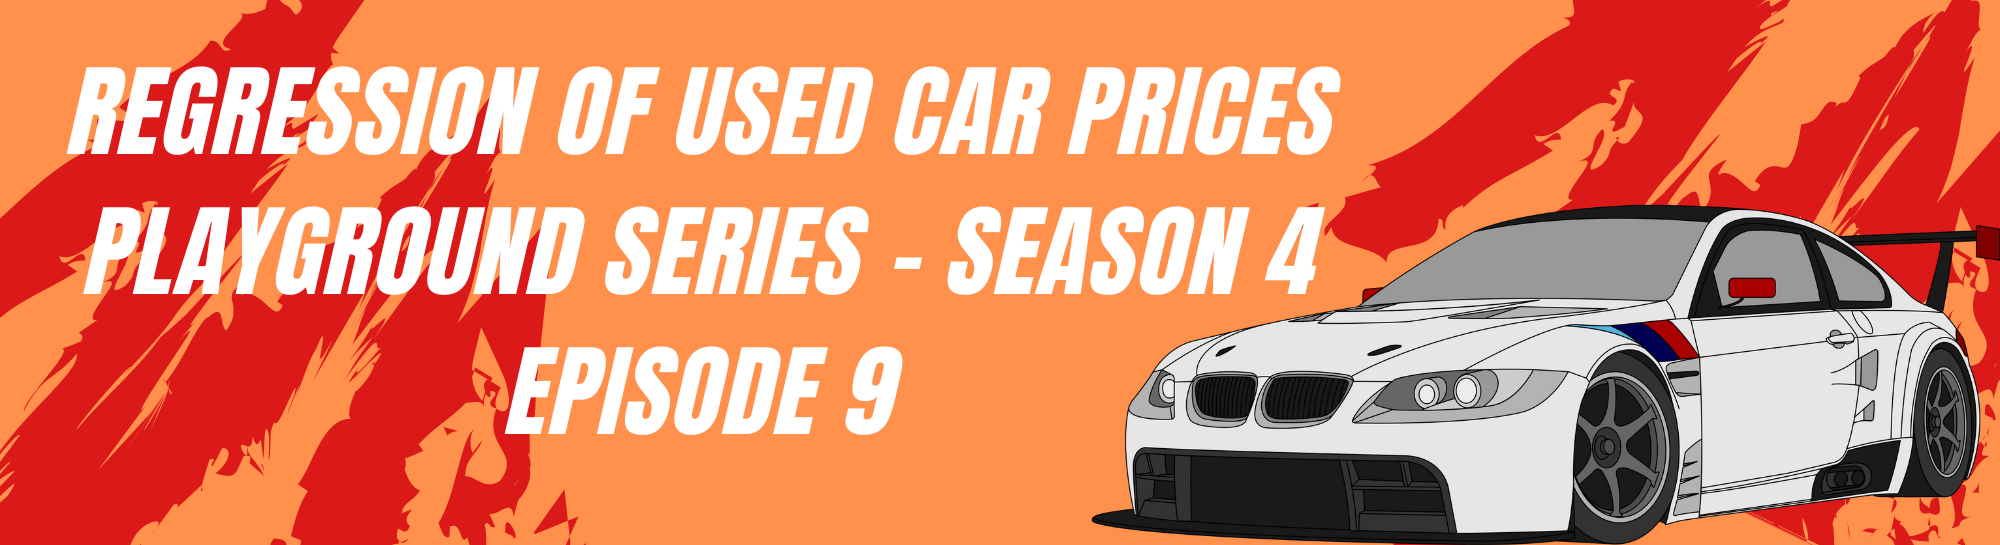

<div style="padding: 20px; border-color: #FF5733; border-radius: 0px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #FF5733; width: 75%; margin: 0 auto; background-color: #FFDAB9;">
    <p style="font-size: 20px; font-family: 'Georgia'; line-height: 1.5em;">
    In this notebook, we explore the Used Car Prices dataset with the objective of predicting car prices. We begin with a comprehensive Exploratory Data Analysis (EDA) to uncover key trends and relationships within the data.
    </p>
    <p style="font-size: 20px; font-family: 'Georgia'; line-height: 1.5em;">
    Following this, we apply targeted feature engineering to enhance the dataset, preparing it for optimal modeling. Finally, we implement the CatBoost, LGBM, and XGBoost algorithms, combining them in an ensemble to build a strong predictive model, emphasizing the technical implementation and evaluation of its performance.
    </p>
</div>


## Import libraries 📚

In [1]:
import numpy as np 
import pandas as pd 
import polars as pl
import os
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool
warnings.simplefilter('ignore')

In [2]:
%%time

train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')


Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

train = pd.concat([train, Original], ignore_index=True)

CPU times: user 904 ms, sys: 112 ms, total: 1.02 s
Wall time: 1.44 s


## Setting Up DataFrame Style ✨

In [3]:
def style_dataframe(df):
    """
    Applies a consistent styling to the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to style.

    Returns:
    pd.io.formats.style.Styler: The styled DataFrame.
    """
    return df.style.set_table_styles(
        [{
            'selector': 'thead th',
            'props': [
                ('background-color', '#FF6F61'),  # Coral Red background for header
                ('color', '#FFFFFF'),  # White text for header
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('border', '1px solid #FFAB40')  # Orange border for header
            ]
        }, {
            'selector': 'tbody td',
            'props': [
                ('background-color', '#F5F5F5'),  # Light gray background for cells
                ('border', '1px solid #DCDCDC'),  # Light gray border for cells
                ('font-weight', 'normal'),
                ('color', '#333333')  # Dark Gray text for readability
            ]
        }]
    ).set_properties(**{'text-align': 'center'}).set_table_attributes('style="width:100%;"').hide(axis='index')

## An overview of the data we are working with 🗃️

In [4]:
# Select a subset (e.g., first 10 rows)
subset_train = train.loc[train.index[:10]]

# Apply styling to the subset
styled_subset_train = style_dataframe(subset_train)

# Display the styled DataFrame
styled_subset_train

id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0.000000,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1.000000,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2.000000,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3.000000,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4.000000,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5.000000,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6.000000,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7.000000,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,White,Gray,None reported,Yes,12500
8.000000,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9.000000,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


<h2 style="text-align: center; font-size: 24px; color: white; font-family: 'Comic Sans MS', cursive; background-color: #FF6F61; padding: 10px; border-radius: 5px;">
    Exploratory Data Analysis and Feature Engineering
</h2>
<p style="text-align: center; font-size: 20px; background-color: #FFDAB9; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: white;">
   In this segment, we conduct Exploratory Data Analysis (EDA) to uncover key patterns and insights within the dataset. We then proceed with feature engineering to refine and enhance the dataset, aiming to improve model performance through optimized features.
</p>


## Feature Types🧩

In [5]:
categorical_features = train.select_dtypes(include='object').columns.tolist()

numerical_features = train.select_dtypes(exclude='object').columns.tolist()

for feature in ['price', 'id']:
    if feature in numerical_features:
        numerical_features.remove(feature)

# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

styled_numerical_df = style_dataframe(df_numerical)
styled_numerical_df

Numerical Variables
model_year
milage


In [6]:
styled_categorical_df = style_dataframe(df_categorical)
styled_categorical_df

Categorical Variables
brand
model
fuel_type
engine
transmission
ext_col
int_col
accident
clean_title


## Analyzing Vehicle Pricing Trends 💲

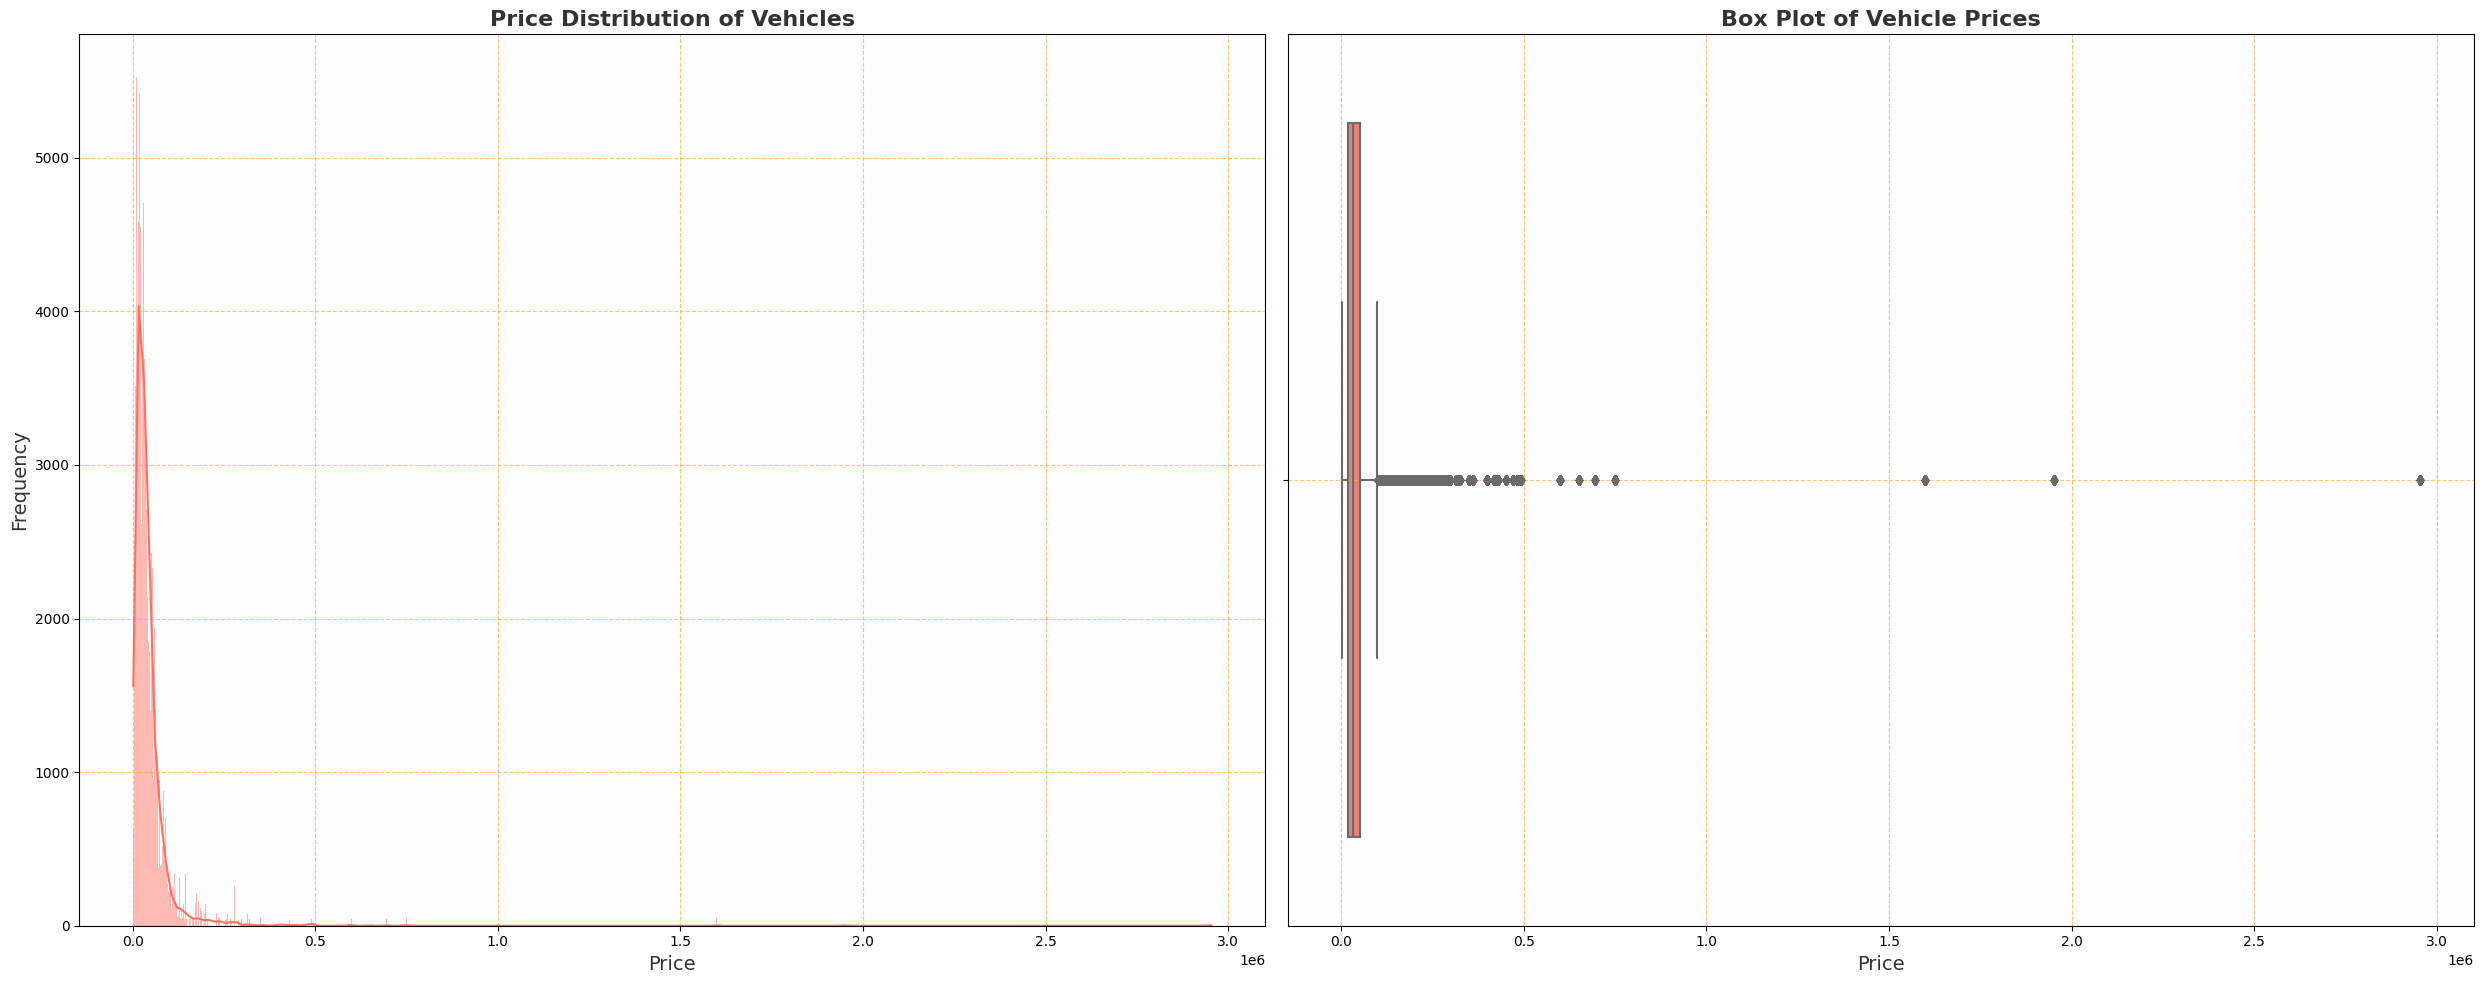

In [7]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# Define new custom color palette
hist_color = '#FF6F61'  # Coral Red for histogram
box_color = '#FF6F61'  # Coral Red for box plot
background_color = '#F5F5F5'  # Light Gray background
grid_color = '#FFAB40'  # Orange for grid lines
text_color = '#333333'  # Dark Gray for text

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Histogram
sns.histplot(train['price'], kde=True, ax=ax[0], color=hist_color)
ax[0].set_title('Price Distribution of Vehicles', fontsize=16, fontweight='bold', color=text_color)
ax[0].set_xlabel('Price', fontsize=14, color=text_color)
ax[0].set_ylabel('Frequency', fontsize=14, color=text_color)
ax[0].patch.set_facecolor(background_color)  # Light Gray background
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Box Plot
sns.boxplot(x=train['price'], ax=ax[1], color=box_color)
ax[1].set_title('Box Plot of Vehicle Prices', fontsize=16, fontweight='bold', color=text_color)
ax[1].set_xlabel('Price', fontsize=14, color=text_color)
ax[1].patch.set_facecolor(background_color)  # Light Gray background
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Adjust layout
plt.tight_layout()
plt.show()

## Fuel Type Distribution Analysis ⛽

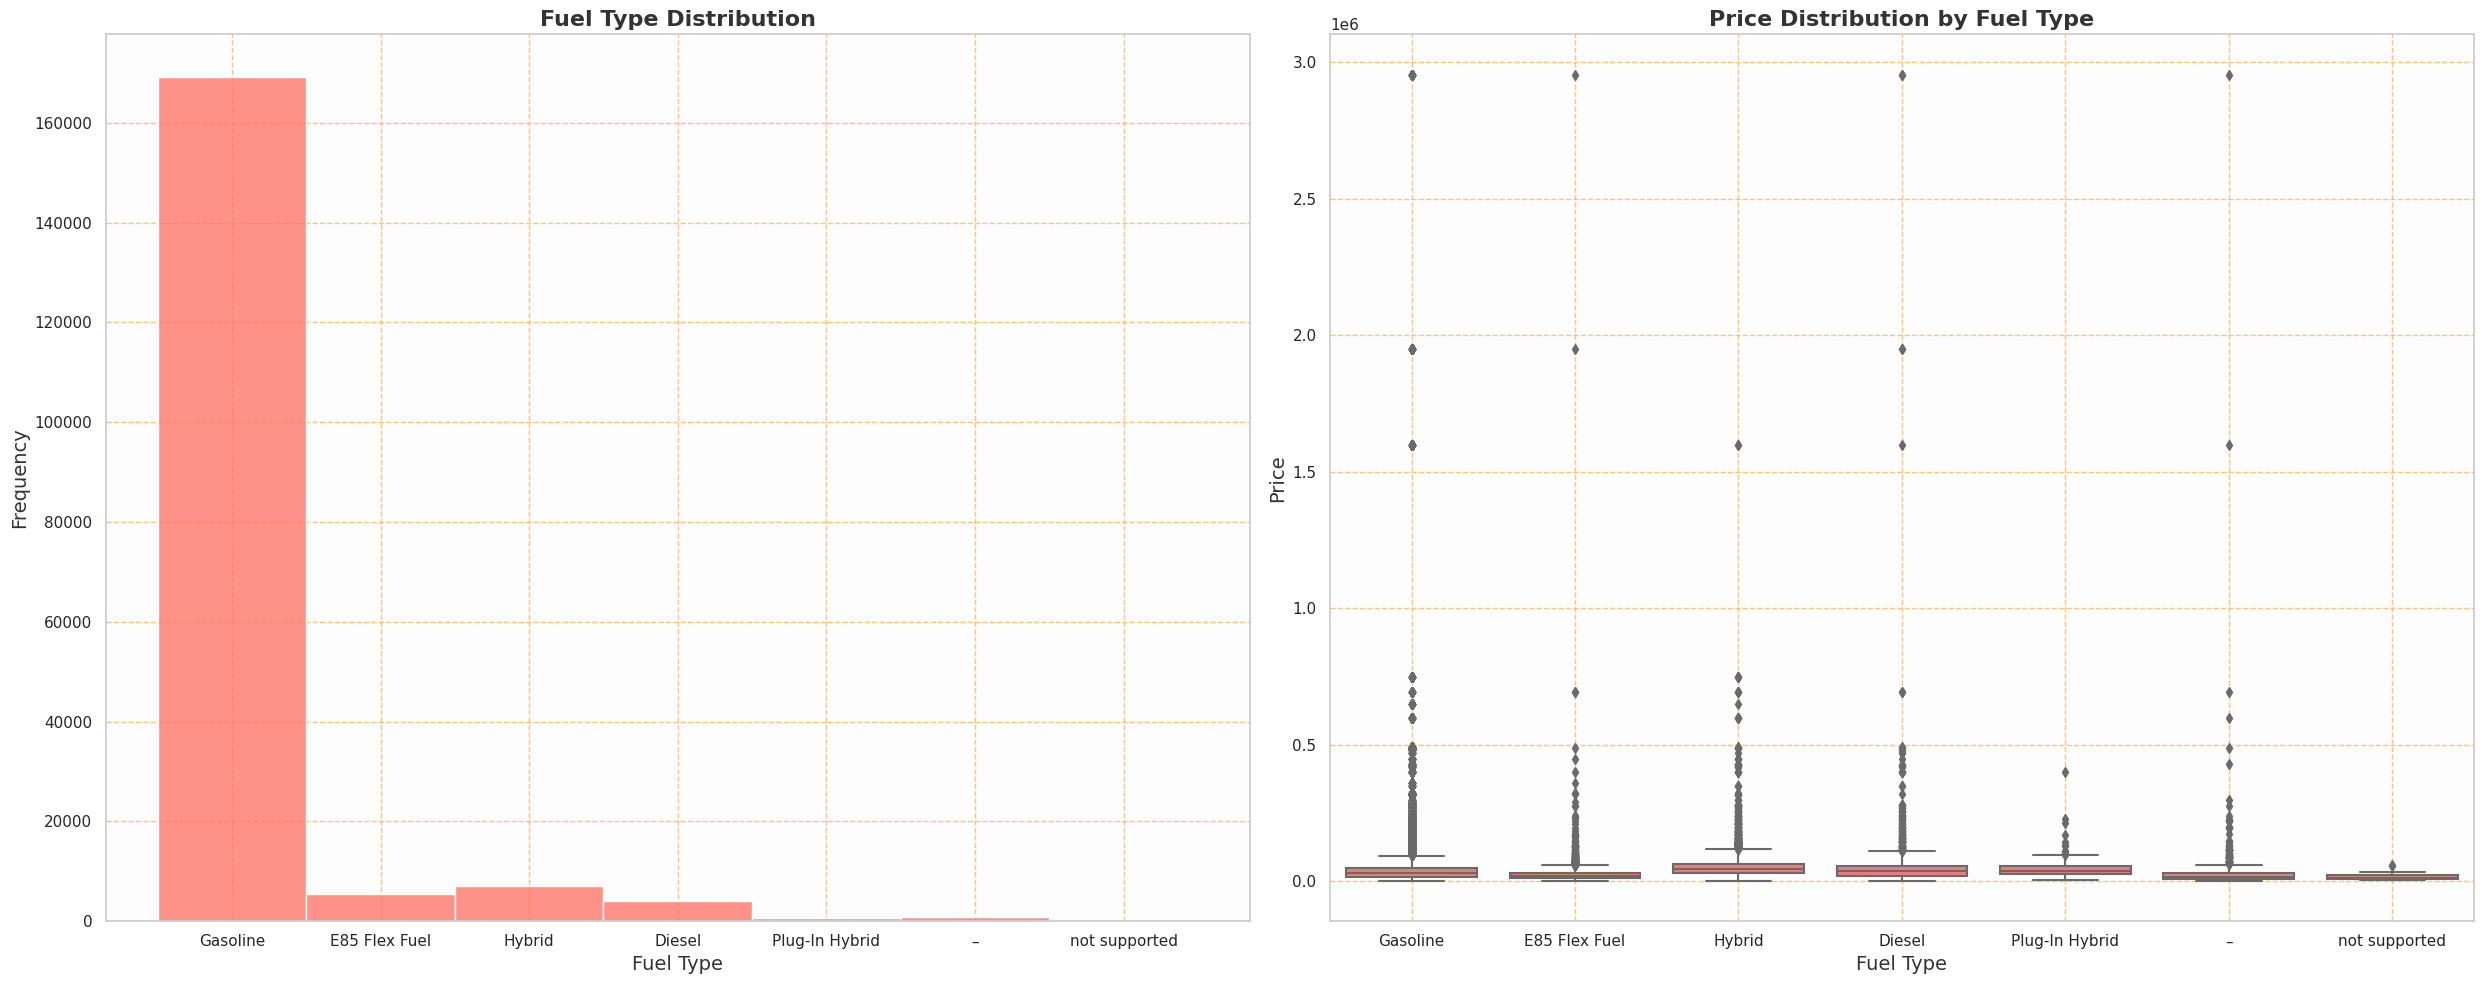

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))  

# Define custom color palette
hist_color = '#FF6F61'  # Coral Red for histogram
box_color = '#FF6F61'  # Coral Red for box plot
background_color = '#F5F5F5'  # Light Gray background
grid_color = '#FFAB40'  # Orange for grid lines
text_color = '#333333'  # Dark Gray for text

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Histogram for Fuel Type
sns.histplot(train['fuel_type'], kde=False, ax=ax[0], color=hist_color)
ax[0].set_title('Fuel Type Distribution', fontsize=16, fontweight='bold', color=text_color)
ax[0].set_xlabel('Fuel Type', fontsize=14, color=text_color)
ax[0].set_ylabel('Frequency', fontsize=14, color=text_color)
ax[0].patch.set_facecolor(background_color)  # Light Gray background
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Box Plot for Price by Fuel Type
sns.boxplot(x='fuel_type', y='price', data=train, ax=ax[1], color=box_color)
ax[1].set_title('Price Distribution by Fuel Type', fontsize=16, fontweight='bold', color=text_color)
ax[1].set_xlabel('Fuel Type', fontsize=14, color=text_color)
ax[1].set_ylabel('Price', fontsize=14, color=text_color)
ax[1].patch.set_facecolor(background_color)  # Light Gray background
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Adjust layout
plt.tight_layout()
plt.show()

## Price Analysis: Model Year and Mileage Insights 📈🚘

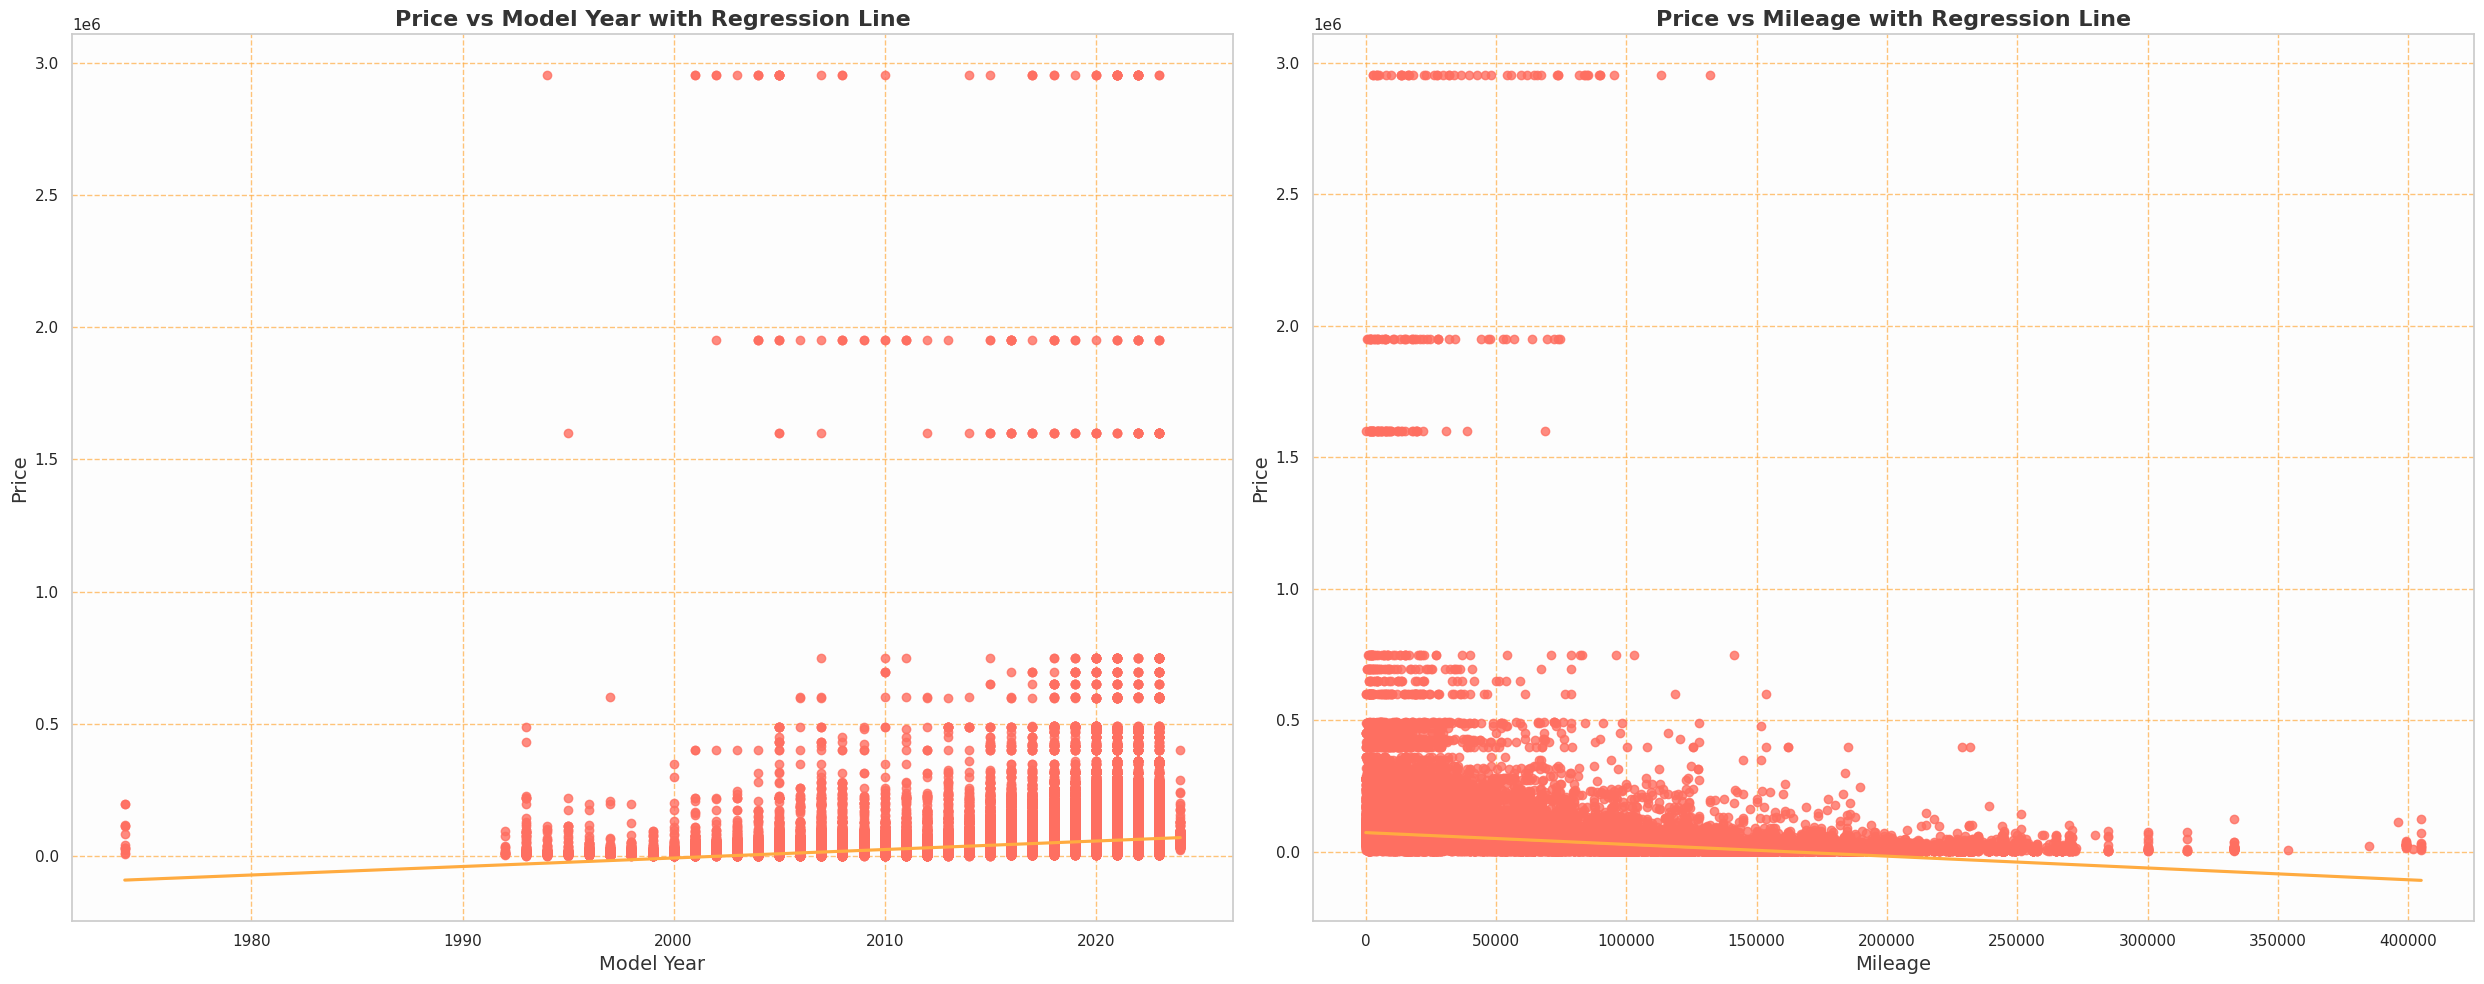

In [9]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))  

# Define custom color palette
scatter_color = '#FF6F61'  # Coral Red for scatter plot
line_color = '#FFAB40'  # Orange for regression line
background_color = '#F5F5F5'  # Light Gray background
grid_color = '#FFAB40'  # Orange for grid lines
text_color = '#333333'  # Dark Gray for text

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Scatter Plot with Regression Line for Price vs Model Year
sns.regplot(x='model_year', y='price', data=train, ax=ax[0], scatter_kws={'color': scatter_color}, line_kws={'color': line_color})
ax[0].set_title('Price vs Model Year with Regression Line', fontsize=16, fontweight='bold', color=text_color)
ax[0].set_xlabel('Model Year', fontsize=14, color=text_color)
ax[0].set_ylabel('Price', fontsize=14, color=text_color)
ax[0].patch.set_facecolor(background_color)  # Light Gray background
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Scatter Plot with Regression Line for Price vs Mileage
sns.regplot(x='milage', y='price', data=train, ax=ax[1], scatter_kws={'color': scatter_color}, line_kws={'color': line_color})
ax[1].set_title('Price vs Mileage with Regression Line', fontsize=16, fontweight='bold', color=text_color)
ax[1].set_xlabel('Mileage', fontsize=14, color=text_color)
ax[1].set_ylabel('Price', fontsize=14, color=text_color)
ax[1].patch.set_facecolor(background_color)  # Light Gray background
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Adjust layout
plt.tight_layout()
plt.show()

## Accident History and Its Impact on Car Prices 🚗💥💵

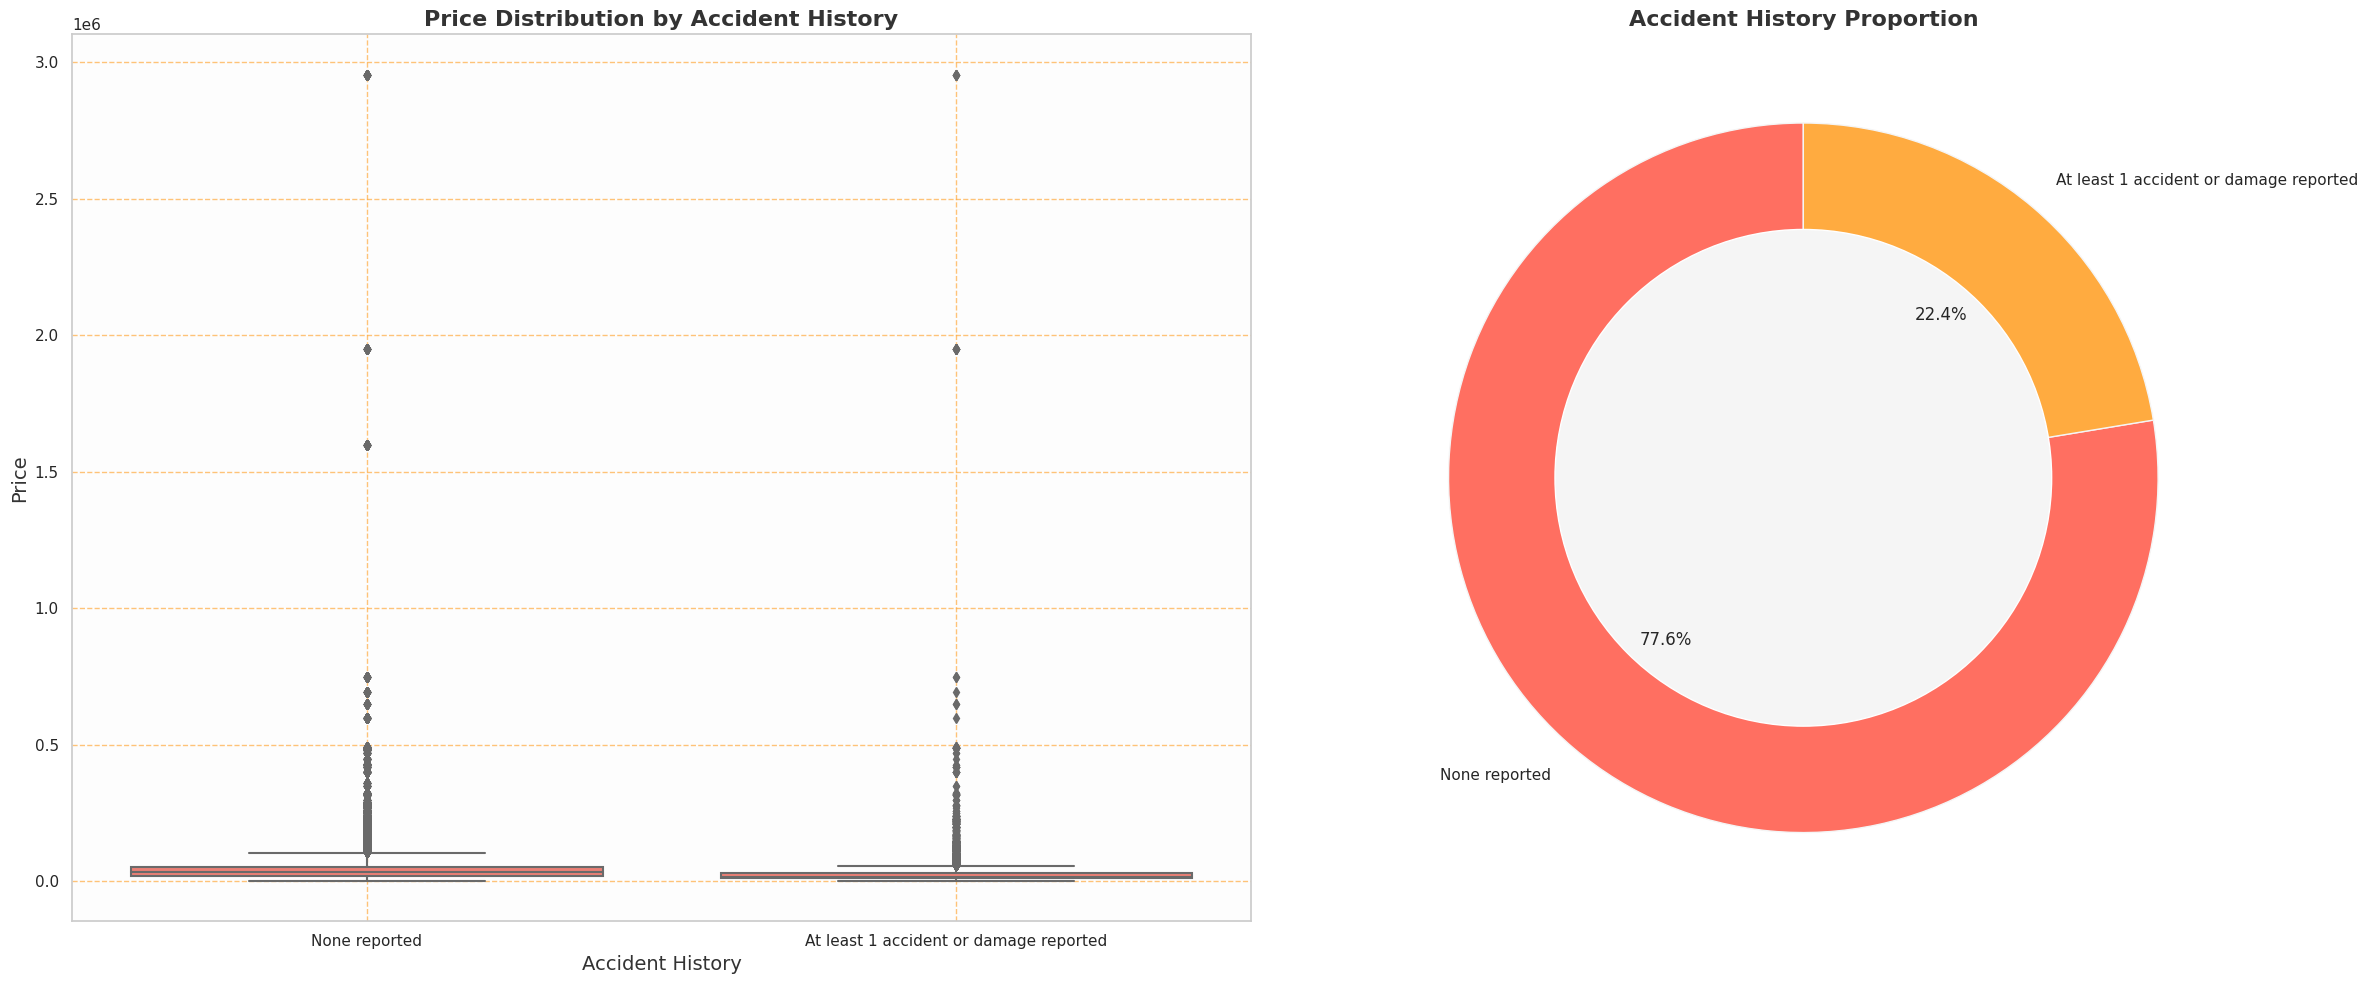

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 10))  # 1 row, 2 columns for side-by-side arrangement

# Define custom color palette
box_color = '#FF6F61'  # Coral Red for box plot
background_color = '#F5F5F5'  # Light Gray background
grid_color = '#FFAB40'  # Orange for grid lines
text_color = '#333333'  # Dark Gray for text
donut_colors = ['#FF6F61', '#FFAB40']  # Coral Red and Orange for donut chart

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Box Plot for Price by Accident History
sns.boxplot(x='accident', y='price', data=train, ax=ax[0], color=box_color)
ax[0].set_title('Price Distribution by Accident History', fontsize=16, fontweight='bold', color=text_color)
ax[0].set_xlabel('Accident History', fontsize=14, color=text_color)
ax[0].set_ylabel('Price', fontsize=14, color=text_color)
ax[0].patch.set_facecolor(background_color)  # Light Gray background
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Donut Chart for Accident History Proportion
accident_counts = train['accident'].value_counts()
ax[1].pie(accident_counts, labels=accident_counts.index, colors=donut_colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': background_color})
centre_circle = plt.Circle((0,0),0.70,fc=background_color)
fig.gca().add_artist(centre_circle)
ax[1].set_title('Accident History Proportion', fontsize=16, fontweight='bold', color=text_color)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing Price Variations Across Brands 🏷️📉

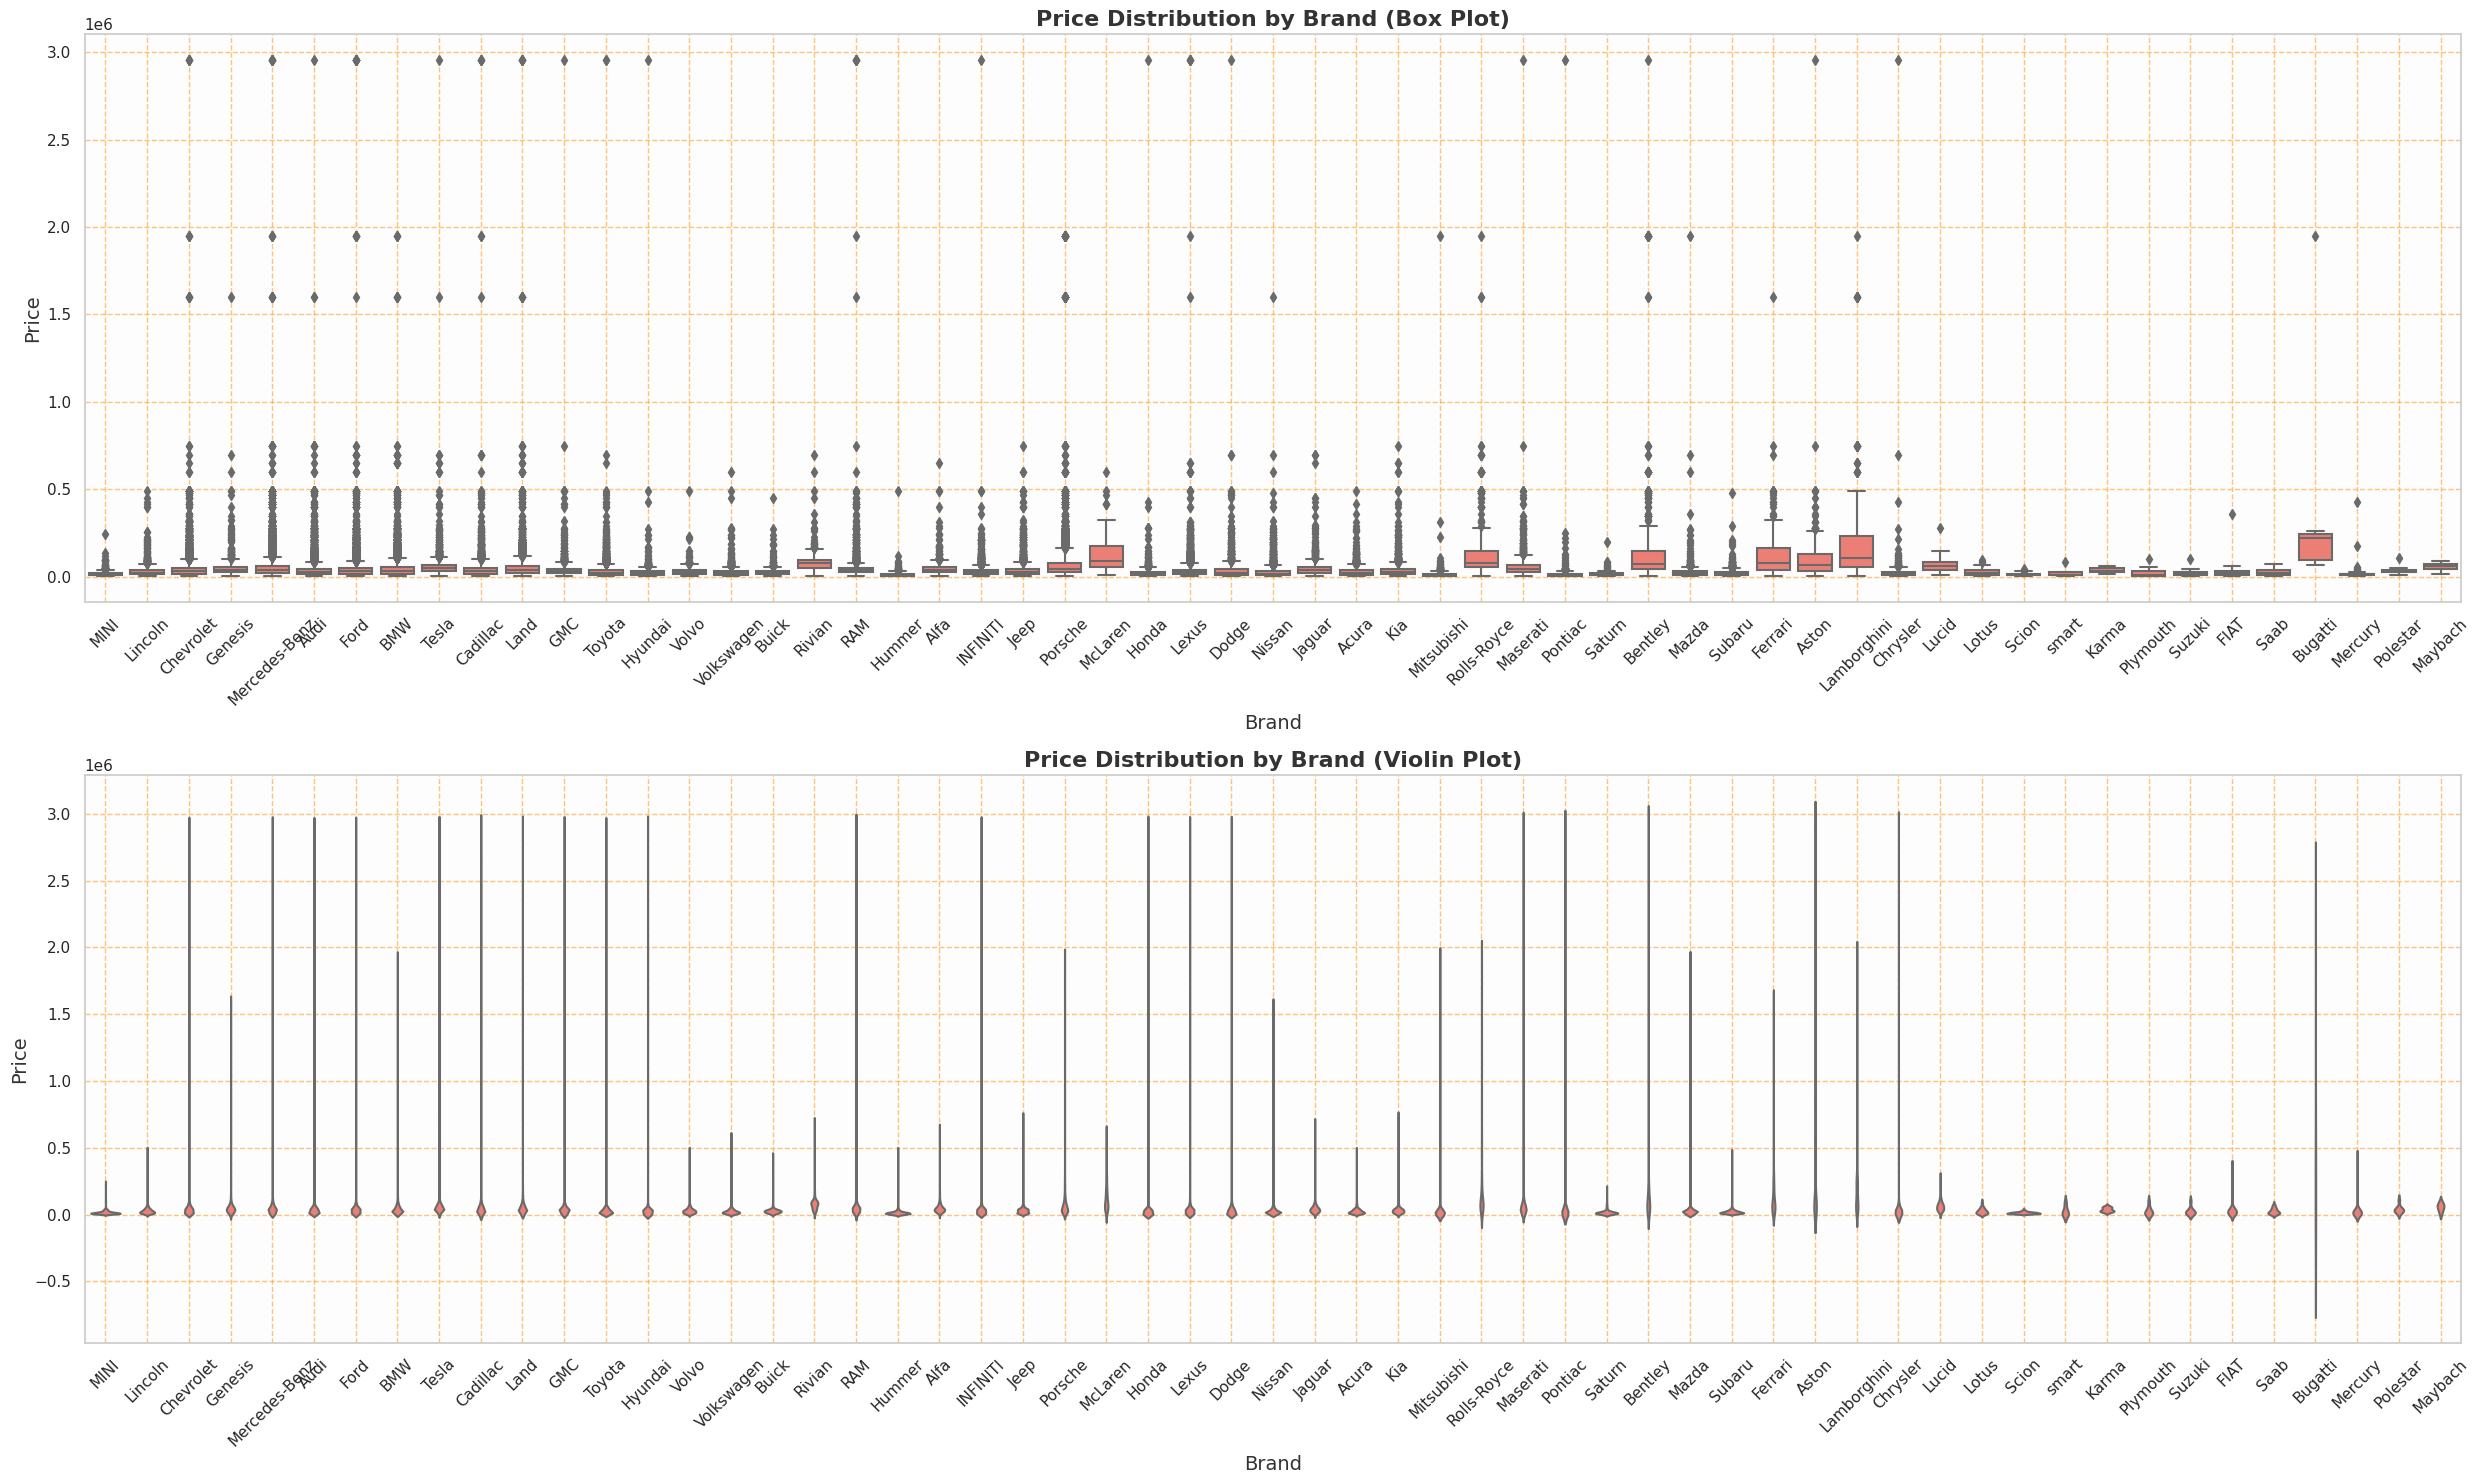

In [11]:
# Set up the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(25, 15)) 

# Define custom color palette
box_color = '#FF6F61'  # Coral Red for box plot
violin_color = '#FF6F61'  # Coral Red for violin plot
background_color = '#F5F5F5'  # Light Gray background
grid_color = '#FFAB40'  # Orange for grid lines
text_color = '#333333'  # Dark Gray for text

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Box Plot for Price by Brand
sns.boxplot(x='brand', y='price', data=train, ax=ax[0], color=box_color)
ax[0].set_title('Price Distribution by Brand (Box Plot)', fontsize=16, fontweight='bold', color=text_color)
ax[0].set_xlabel('Brand', fontsize=14, color=text_color)
ax[0].set_ylabel('Price', fontsize=14, color=text_color)
ax[0].patch.set_facecolor(background_color)  # Light Gray background
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines
ax[0].tick_params(axis='x', rotation=45)

# Violin Plot for Price by Brand
sns.violinplot(x='brand', y='price', data=train, ax=ax[1], color=violin_color, inner=None)
ax[1].set_title('Price Distribution by Brand (Violin Plot)', fontsize=16, fontweight='bold', color=text_color)
ax[1].set_xlabel('Brand', fontsize=14, color=text_color)
ax[1].set_ylabel('Price', fontsize=14, color=text_color)
ax[1].patch.set_facecolor(background_color)  # Light Gray background
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Distribution of Top 10 Exterior and Interior Colors 📊🚗

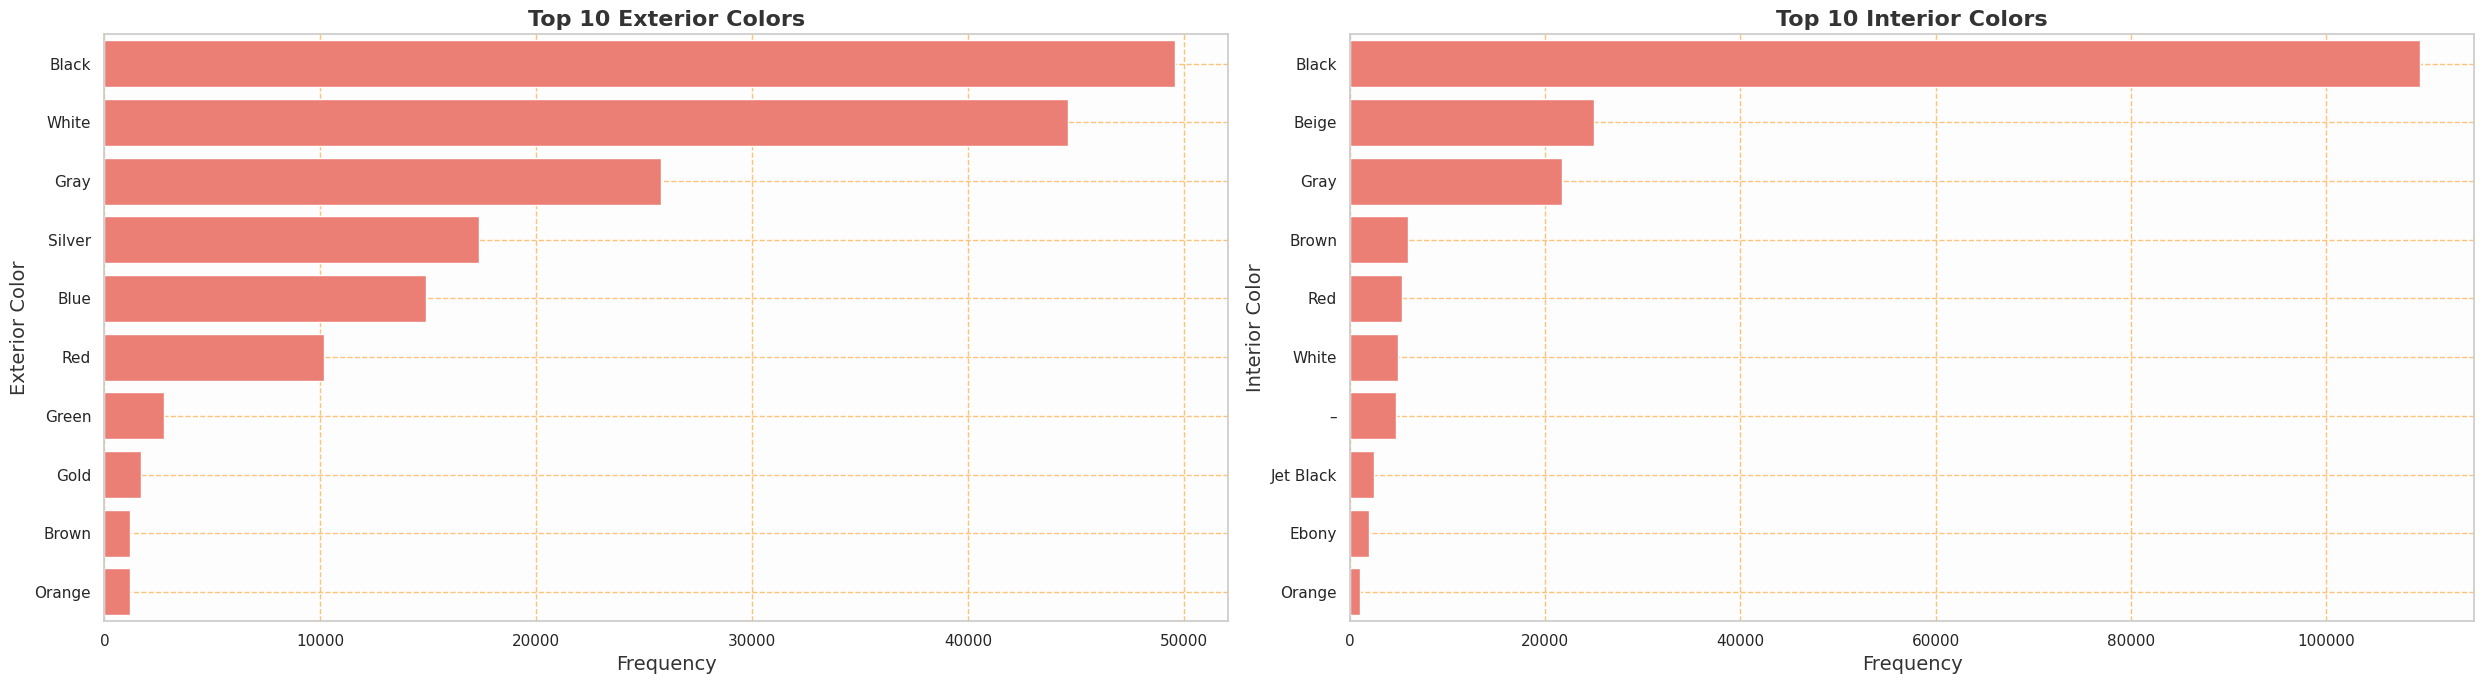

In [12]:
# Assuming 'train' is your DataFrame
top_n = 10  # Top N categories to visualize

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25, 7))  # 1 row, 2 columns for side-by-side plots

# Define custom color palette
bar_color = '#FF6F61'  # Coral Red for bar plots
background_color = '#F5F5F5'  # Light Gray background
grid_color = '#FFAB40'  # Orange for grid lines
text_color = '#333333'  # Dark Gray for text

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Bar Plot for Top 10 Exterior Colors
ext_color_counts = train['ext_col'].value_counts().head(top_n)
sns.barplot(x=ext_color_counts.values, y=ext_color_counts.index, ax=ax[0], palette=[bar_color])
ax[0].set_title('Top 10 Exterior Colors', fontsize=16, fontweight='bold', color=text_color)
ax[0].set_xlabel('Frequency', fontsize=14, color=text_color)
ax[0].set_ylabel('Exterior Color', fontsize=14, color=text_color)
ax[0].patch.set_facecolor(background_color)  # Light Gray background
ax[0].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[0].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Bar Plot for Top 10 Interior Colors
int_color_counts = train['int_col'].value_counts().head(top_n)
sns.barplot(x=int_color_counts.values, y=int_color_counts.index, ax=ax[1], palette=[bar_color])
ax[1].set_title('Top 10 Interior Colors', fontsize=16, fontweight='bold', color=text_color)
ax[1].set_xlabel('Frequency', fontsize=14, color=text_color)
ax[1].set_ylabel('Interior Color', fontsize=14, color=text_color)
ax[1].patch.set_facecolor(background_color)  # Light Gray background
ax[1].patch.set_alpha(0.1)  # Adjust alpha for transparency
ax[1].grid(True, linestyle='--', alpha=0.7, color=grid_color)  # Orange grid lines

# Adjust layout
plt.tight_layout()
plt.show()

## Transmission Type Breakdown 🚗🔍

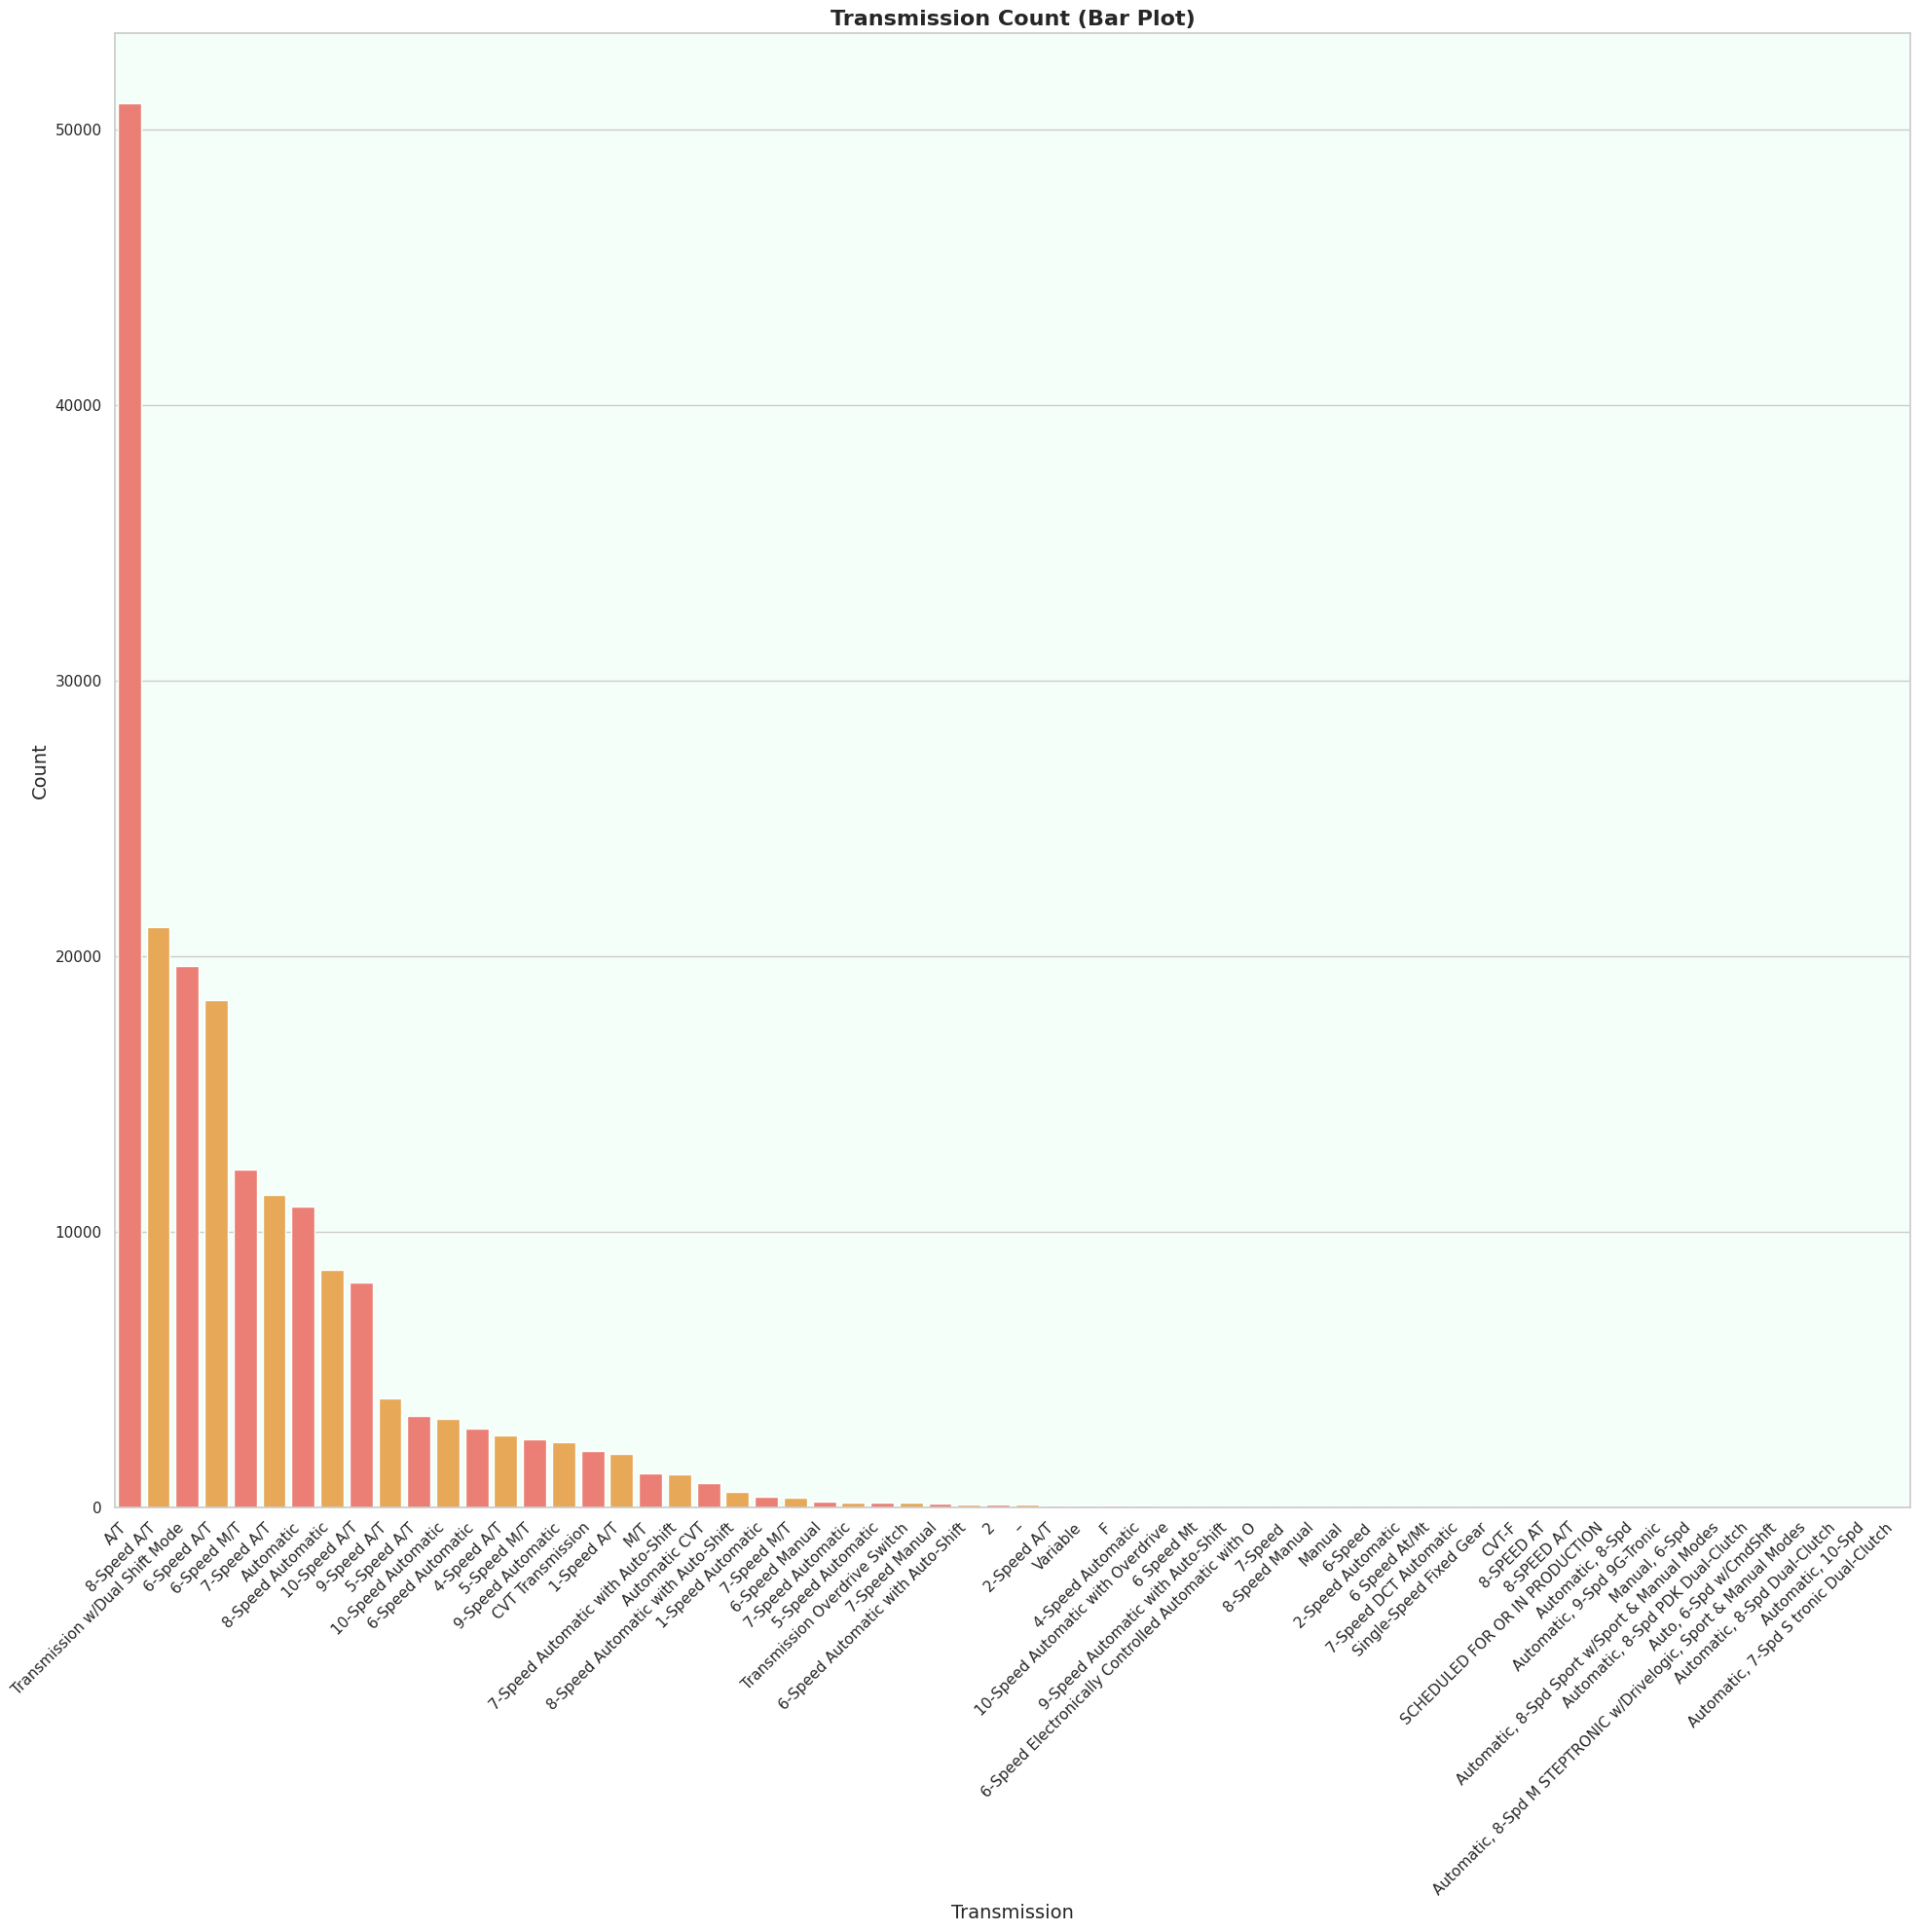

In [13]:
# Define custom color palette
custom_palette = ['#FF6F61', '#FFAB40']  # Coral Red for count plot

# Set up the figure
plt.figure(figsize=(20, 20))  # Increased size for better visibility

# Create the count plot
sns.countplot(x='transmission', data=train, palette=custom_palette, order=train['transmission'].value_counts().index)

# Title and labels
plt.title('Transmission Count (Bar Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Transmission', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adjust x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

# Background color
plt.gca().set_facecolor('#F5FFFA')  # Light Gray background

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Show plot
plt.show()

## Identifying Missing Values in the Dataset 🔍

In [14]:
train.isna().sum()

id               4009
brand               0
model               0
model_year          0
milage              0
fuel_type        5253
engine              0
transmission        0
ext_col             0
int_col             0
accident         2565
clean_title     22015
price               0
dtype: int64

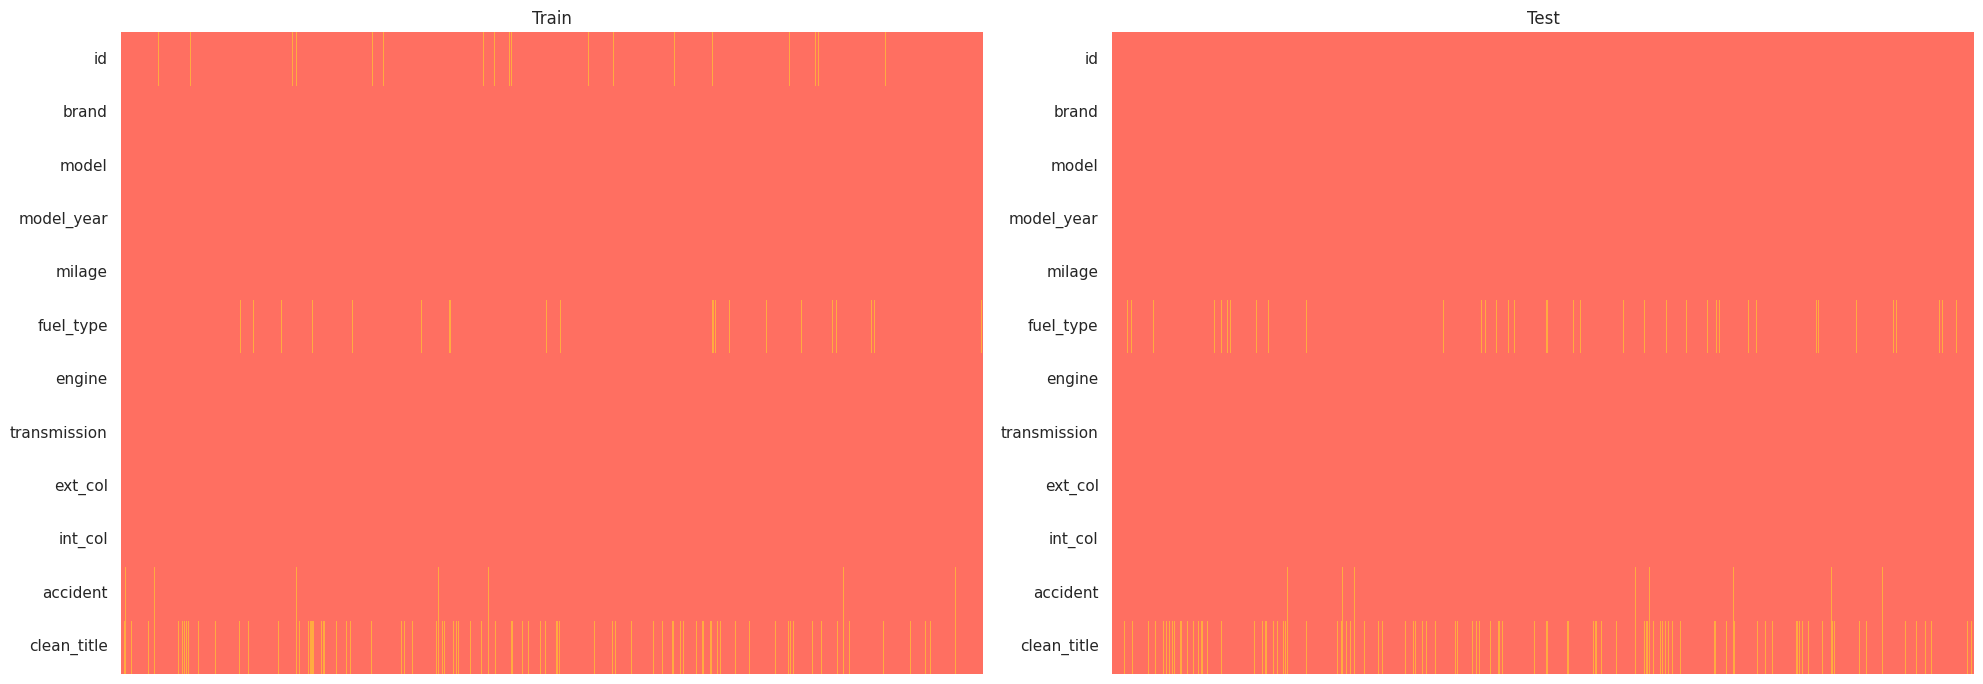

In [15]:
# Custom color palette
custom_palette = ['#FF6F61', '#FFAB40']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# Sample data for null values heatmap
train_null_values = train.sample(100_000).drop(columns=['price']).isnull().T
test_null_values = test.sample(100_000).isnull().T

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

## Feature Engineering 🛠️ 

In [16]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

In [17]:
cat_features = test.select_dtypes('object').columns
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
for feature in cat_features:          
    categories = sorted(list(set(train[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train.loc[~train[feature].isin(categories), feature] = np.nan
    test.loc[~test[feature].isin(categories), feature] = np.nan
    
    train[feature] = train[feature].astype(dtype)
    test[feature] = test[feature].astype(dtype)

<h2 style="text-align: center; font-size: 24px; color: white; font-family: 'Comic Sans MS', cursive; background-color: #FF6F61; padding: 10px; border-radius: 5px;">
    Model Training and Optimization
</h2>
<p style="text-align: center; font-size: 20px; background-color: #FFDAB9; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #FF6F61;">
   In this section, we build and train an Ensemble model using CatBoost, XGBoost, and LightGBM to make predictions based on our dataset. We enhance the model's performance through careful hyperparameter tuning. Once the training is complete, we generate predictions and format them for submission, ensuring that our results are accurately prepared for evaluation.
</p>


## XGBoost

In [18]:
X_train = train.drop(columns=["id", "price"])
y_train = train["price"]

X_test = test.drop(columns=["id"])

In [19]:
#I have used 5 splits here.
def cross_validate_model_x(model, X_train, y_train, params, n_splits=5):

    # Initialize variables
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params, enable_categorical=True)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train,  eval_set=[(X_val, y_val)],verbose=500, early_stopping_rounds=50)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [20]:
xgb_params={
    
'lambda': 0.17694956261235095,
 'alpha': 1.3889763984339085,
 'colsample_bytree': 0.7,
 'subsample': 1.0,
 'learning_rate': 0.008,
 'max_depth': 17,
 'random_state': 2020,
 'min_child_weight': 59,
 'n_estimators': 10000,
 'tree_method': 'gpu_hist'
 
}


print('XGBoost Cross-Validation Results:\n')
xgb_model, test_predsx = cross_validate_model_x(XGBRegressor, X_train, y_train, xgb_params)

XGBoost Cross-Validation Results:

[0]	validation_0-rmse:80885.04154
[398]	validation_0-rmse:75226.60223
--------------------------------------------------
[[19037.531     0.        0.        0.        0.   ]
 [80735.19      0.        0.        0.        0.   ]
 [51961.17      0.        0.        0.        0.   ]
 ...
 [20893.834     0.        0.        0.        0.   ]
 [16616.227     0.        0.        0.        0.   ]
 [51883.707     0.        0.        0.        0.   ]]
[0]	validation_0-rmse:74363.98273
[381]	validation_0-rmse:68062.83053
--------------------------------------------------
[[19037.531 18732.354     0.        0.        0.   ]
 [80735.19  84783.695     0.        0.        0.   ]
 [51961.17  48369.16      0.        0.        0.   ]
 ...
 [20893.834 21952.205     0.        0.        0.   ]
 [16616.227 17216.615     0.        0.        0.   ]
 [51883.707 36909.445     0.        0.        0.   ]]
[0]	validation_0-rmse:75790.56786
[361]	validation_0-rmse:69552.66468
-----

In [21]:
xgb_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
xgb_result['price'] = test_predsx.astype(np.float32)
xgb_result

,id,price
0,188533,18932.646484
1,188534,83670.929688
2,188535,52087.875000
3,188536,31151.156250
4,188537,30012.619141
...,...,...
125685,314218,33796.226562
125686,314219,54072.843750
125687,314220,21321.498047
125688,314221,16984.417969


## LGBM

In [22]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')


Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

train = pd.concat([train, Original], ignore_index=True)

Performing different kind of feature engineering here because while XGBoost handles null and categorical data well, CatBoost and LightGBM may encounter performance issues and have specific requirements.

In [23]:
def update(df):
    
    t = 100
    
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title']
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

train  = update(train)
test   = update(test)

In [24]:
X_train = train.drop(columns=["id", "price"])
y_train = train["price"]

X_test = test.drop(columns=["id"])

In [25]:
def cross_validate_model_l(model, X_train, y_train, params, n_splits=10):

    # Initialize variables
    callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], callbacks=callbacks )
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [26]:
from lightgbm import LGBMRegressor
# params are taken from this notebook: https://www.kaggle.com/code/noodl35/optuna-lgbm-tuning-used-cars
lgb_params = {
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 10000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1             # Set to -1 for silent mode, no process information printed
}

print('LightGBM Cross-Validation Results:\n')
lgb_model,test_predsl = cross_validate_model_l(LGBMRegressor, X_train, y_train, lgb_params)

LightGBM Cross-Validation Results:

Training until validation scores don't improve for 200 rounds
[150]	valid_0's rmse: 72236.5
[300]	valid_0's rmse: 71913.9
[450]	valid_0's rmse: 71929
Early stopping, best iteration is:
[362]	valid_0's rmse: 71901.9
--------------------------------------------------
[[18038.68      0.        0.    ...     0.        0.        0.   ]
 [74499.37      0.        0.    ...     0.        0.        0.   ]
 [56795.23      0.        0.    ...     0.        0.        0.   ]
 ...
 [19574.594     0.        0.    ...     0.        0.        0.   ]
 [14350.613     0.        0.    ...     0.        0.        0.   ]
 [41088.79      0.        0.    ...     0.        0.        0.   ]]
Training until validation scores don't improve for 200 rounds
[150]	valid_0's rmse: 78470.7
[300]	valid_0's rmse: 78250.4
[450]	valid_0's rmse: 78321.4
Early stopping, best iteration is:
[261]	valid_0's rmse: 78233.8
--------------------------------------------------
[[18038.68  18441.363 

In [27]:
lgb_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
lgb_result['price'] = test_predsl.astype(np.float32)
lgb_result

,id,price
0,188533,17690.228516
1,188534,78722.164062
2,188535,53061.667969
3,188536,31533.843750
4,188537,28839.781250
...,...,...
125685,314218,30847.910156
125686,314219,53771.667969
125687,314220,20005.833984
125688,314221,15102.117188


## CatBoost

In [28]:
#I have used 5 splits here.
def cross_validate_model_c(model, X_train, y_train, params, n_splits=10):

    # Initialize variables
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], verbose=0)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [29]:
from catboost import CatBoostClassifier

cat_params = {
    'cat_features':cat_cols,  
    'learning_rate': 0.075,
    'iterations': 5000,
    'depth': 9,
    'random_strength': 0,
    'l2_leaf_reg': 0.5,
    'task_type': 'GPU',
    'max_leaves': 512,
    'fold_permutation_block': 64,
    'random_seed': 42,
    'verbose': False                      
}

print('CatBoost Cross-Validation Results:\n')
cat_model, test_predsc = cross_validate_model_c(CatBoostRegressor, X_train, y_train, cat_params)

CatBoost Cross-Validation Results:

--------------------------------------------------
[[19051.285     0.        0.    ...     0.        0.        0.   ]
 [82156.9       0.        0.    ...     0.        0.        0.   ]
 [55807.824     0.        0.    ...     0.        0.        0.   ]
 ...
 [20211.176     0.        0.    ...     0.        0.        0.   ]
 [15461.355     0.        0.    ...     0.        0.        0.   ]
 [35596.85      0.        0.    ...     0.        0.        0.   ]]
--------------------------------------------------
[[19051.285 19148.688     0.    ...     0.        0.        0.   ]
 [82156.9   81708.945     0.    ...     0.        0.        0.   ]
 [55807.824 56886.32      0.    ...     0.        0.        0.   ]
 ...
 [20211.176 22789.895     0.    ...     0.        0.        0.   ]
 [15461.355 17183.31      0.    ...     0.        0.        0.   ]
 [35596.85  35419.273     0.    ...     0.        0.        0.   ]]
----------------------------------------------

In [30]:
cat_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
cat_result['price'] = test_predsc.astype(np.float32)
cat_result

,id,price
0,188533,19057.246094
1,188534,80261.828125
2,188535,56626.570312
3,188536,29336.750000
4,188537,31977.894531
...,...,...
125685,314218,31408.925781
125686,314219,56581.386719
125687,314220,20901.835938
125688,314221,15934.815430


## Building a Prediction Ensemble 🏗️🤖

In [31]:
Pred = pd.concat([lgb_result,cat_result,xgb_result], axis=1)['price']
print(Pred)
test_preds = test_predsl * 0.7 + test_predsc * 0.1 + test_predsx*0.2

               price         price         price
0       17690.228516  19057.246094  18932.646484
1       78722.164062  80261.828125  83670.929688
2       53061.667969  56626.570312  52087.875000
3       31533.843750  29336.750000  31151.156250
4       28839.781250  31977.894531  30012.619141
...              ...           ...           ...
125685  30847.910156  31408.925781  33796.226562
125686  53771.667969  56581.386719  54072.843750
125687  20005.833984  20901.835938  21321.498047
125688  15102.117188  15934.815430  16984.417969
125689  41535.699219  35494.226562  44022.523438

[125690 rows x 3 columns]


In [32]:
ensemble_sub =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
ensemble_sub['price'] = test_preds

ensemble_sub.to_csv('submission.csv', index=False)